In [15]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import os
import cv2
import numpy as np
from xception_gcn_seg import XceptionGCNSegmentation
from resnet_gcn_seg import ResnetGCNSegmentation
from desnet_gcn_seg import DensenetGCNSegmentation
from MobileNetDenseASPP import DenseASPP
from resnext_gcn_seg import ResNeXtGCNSegmentation
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
net = ResNeXtGCNSegmentation()
model_name = 'snapshot_33_G_model'
net = nn.DataParallel(net).cuda()
checkpoint = torch.load(model_name)
net.load_state_dict(checkpoint)
net.eval()
norm_mean = [0.406, 0.456, 0.485]
norm_std = [0.225, 0.224, 0.229]
norm = {'mean': norm_mean, 'std': norm_std}

In [17]:
f = open('val/val.txt','r')
lines = f.readlines()
f.close()

In [18]:
for line in lines:
    imagepath = line.split(' ')[0]
    img = cv2.imread(imagepath)
    try:
        img_rs = cv2.resize(img,(512,512), interpolation=cv2.INTER_CUBIC)
    except:
        continue
    else:
        input_tensor = img_rs.transpose((2, 0, 1))
        input_tensor = torch.from_numpy(input_tensor).float()
        input_tensor = input_tensor.div(255.0)
        normalize = transforms.Normalize(norm['mean'], norm['std'])
        input_tensor = normalize(input_tensor)
        input_tensor = torch.unsqueeze(input_tensor, 0)
        input_tensor = Variable(input_tensor, volatile=True)
        outputs = net(input_tensor.cuda())
        img_mask = outputs['output'].cpu().data.numpy()
        img_mask = np.squeeze(img_mask).astype('uint8')
        mask_name = imagepath.split('/')[-1][:-4] + '_mask.png'
        cv2.imwrite('resnext_final/'+mask_name, img_mask)

resnext_gcn_seg.py:348: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_output = F.softmax(out)


In [29]:
def _iou(a, b, label):
        s = (a == label).astype(np.float32) + (b == label).astype(np.float32)
        #print (s)
        ins = (s == 2).sum()
        #print ('ins:'+str(ins))
        union = (s >= 1).sum()
        return ins*1.0 / union if union > 0 else 0

score_dict = {}
for idx in range(6):
        score_dict['class_%s' % idx] = 0
        score_dict['num_class_%s' % idx] = 0
for root,direction,files in os.walk('resnext_final/'):
    for file in files:
        output = cv2.imread(os.path.join(root,file),0)
        if file[0] == '0':         
            groundtruth = cv2.imread('anno/'+file,0)
        else:
            groundtruth = cv2.imread('anno/'+file[:-9]+'_seg.png',0)
        try:
            groundtruth = cv2.resize(groundtruth,(512,512))
        except:
            continue
        else:
            label_num = np.unique(groundtruth)
            #print (label_num)
            for idx in label_num:
                iou = _iou(output, groundtruth, idx)
                #if iou:
                score_dict['class_%s' % idx] = score_dict['class_%s' % idx]+iou
                score_dict['num_class_%s' % idx] = score_dict['num_class_%s' % idx] + 1
for idx in range(6):
    score_dict['average_iou_%s'%idx] = score_dict['class_%s' % idx]/score_dict['num_class_%s' % idx]
score_dict['mean_iou']=(score_dict['average_iou_0']+score_dict['average_iou_1']+score_dict['average_iou_2']+score_dict['average_iou_3']+score_dict['average_iou_4']+score_dict['average_iou_5'])/6

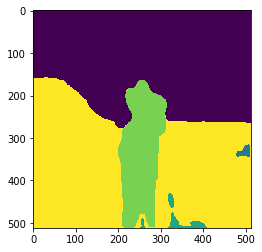

In [30]:
score_dict

True